# Unlocking Church Growth: Data Insights from the National Congregations Study

**Author**: Nathan Schaaf <br>
**Date**: July 10, 2024

## References
Chaves, M. (2021, January 25). National Congregations Study, Cumulative Dataset (1998, 2006-2007, 2012, and 2018-2019). The Association of Religion Data Archives. doi:10.17605/OSF.IO/V5ZKB. https://www.thearda.com/data-archive?fid=NCSIV.


## Objective / Thesis
How can we increase our church attendance? In this analysis we explore the "National Congregations Study, Cumuliative Dataset (1998, 2006-2007, 2012, and 2018-2019)" to look for correlations between congregational offerings such as facilities, worship services, staffing, music, and programs and an increase congregational size. The dataset includes over 5,000 congregations sampled through in-person interviews in four periods between 1998 and 2019. This analysis is inteded for decision-makers within religious congregations.

## Data Understanding and Preparation
Data Cleaning: Ensure the dataset is clean, dealing with missing values, and outliers. <br>
Data Transformation: Create relevant variables, such as attendance growth rates, and standardize/normalize data if necessary.

### Dependencies
Import libraries needed for this notebook. These may be used in a future requirements.txt file for modular project development.

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from scipy.stats import spearmanr, pearsonr, chi2_contingency, fisher_exact
from scipy.stats.contingency import relative_risk
from scipy.stats.contingency import odds_ratio
from scipy.stats import f_oneway  # Inferential Analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE # Rancom Forest oversampling


# Import DictionaryCollection class from Dictionaries.py
    # Download the file from GitHub
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/notebook/dictionaries.py'
response = requests.get(url)

    # Save the file locally
with open('dictionaries.py', 'wb') as file:
    file.write(response.content)
from dictionaries import dictionaryCollection

Unfortunately, the data source altered all categorical data into ordinal values and all Boolean data into ‘1’ and ‘2’, yes/no respectively. The above dictionaries.py file implements the provided translational text documents from the data source by converting the ordinal values back into categorical data. It also converts the 2’s into 0 achieving standard Boolean representation to avoid confusion and modeling issues.

In [3]:
# Load Data
url = 'https://raw.githubusercontent.com/NRSchaaf/unlocking-church-growth/main/dataset/dataset.csv'
data = pd.read_csv(url)

Loading the dataset directly from the GitHub repository can aid others in reviewing, replicating, or continuting this analysis. Unfortuantly, no APIs were avaialble to access the dataset directly from the source.

In [4]:
# Initialize DictionaryCollection instance
dict_collection = dictionaryCollection()

# Replace numerical values column with string values from dictionaries
data = dict_collection.replace_numeric_values(data)

Create a custom theme for all Seaborn visualizations.

In [5]:
# Custom Theme
def set_seaborn_style(font_family, background_color, grid_color, text_color):
    sns.set_style({
        "axes.facecolor": background_color,
        "figure.facecolor": background_color,

        "grid.color": grid_color,
        "axes.edgecolor": grid_color,
        "axes.grid": True,
        "axes.axisbelow": True,
        
        "axes.labelcolor": text_color,
        "text.color": text_color,
        "font.family": font_family,
        "xtick.color": text_color,
        "ytick.color": text_color,

        "xtick.bottom": False,
        "xtick.top": False,
        "ytick.left": False,
        "ytick.right": False,

        "axes.spines.left": False,
        "axes.spines.bottom": True,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
)

background_color = "#006064"
grid_color = "#cccccc"
bar_color = "#009688"
text_color = "#ffffff"
font_family = "Arial"

set_seaborn_style(font_family, background_color, grid_color, text_color)

The denomination is a key categorical feature of the dataset for the analysis reader. Religious beliefs can influence behaviors, values, lifestyle choice and practices of a congregation and its members. They can also play a crucial role in social interactions and cultural norms. Since there is over 60 denominations surveyed in this dataset, a custom color palette for denominations has been created below so each is represented by a consistent color in any visual analytics. 

In [6]:
# Create a custom color palette for all denominations
#denominations = data['DENOM'].unique()
#colors = sns.color_palette('Set2', len(denominations))
#custom_palette = dict(zip(denominations, colors))

### Data Transformation

In [7]:
# Create new features based on conditions
data['change_category'] = data['CHANGE'].apply(
    lambda x: "Increase" if "Increased" in str(x) else ("Decrease" if "Decreased" in str(x) else ("Same" if "Same" in str(x) else "Same"))
)

In [8]:
# Change column data types
data['DENOM'] = data['DENOM'].astype('category')
data['change_category'] = data['change_category'].astype('category')

### Data Cleaning

## Descriptive Analysis
Summary Statistics: Compute basic statistics (mean, median, mode) for variables related to facilities, worship services, staffing, music, programs, and congregational size. <br>
Distribution Analysis: Visualize the distributions of key variables to understand their spread and central tendency.

### Source Dataframe

In [9]:
# Basic Exploration
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Columns: 1089 entries, CASEID to change_category
dtypes: category(2), float64(1019), int64(11), object(57)
memory usage: 44.2+ MB


,CASEID,YEAR,REGION,POS1,RTENURE,FOUNDED,STRTWRSH,HAVEDEN,DENCODE,DENCODE3,...,WT_WAVE4_ATTENDEE,POOR30_ALL4,BLCK80_4,HISPANIC_ALL4,URBAN_ALL4,I_YEAR,I_REGION,I_THEOLOGY,I_POLITICS,I_RELIGION
count,5333.000000,5333.000000,5333.000000,5319.000000,1502.000000,5171.000000,1191.000000,5333.000000,5333.000000,5333.000000,...,744.000000,5329.000000,5330.000000,5330.000000,5330.000000,5333.000000,5333.000000,5187.000000,5068.000000,5333.000000
mean,2667.147197,2008.486030,2.638477,3.272984,128.674434,1930.442854,1945.212427,1.140446,12.775923,9.372773,...,1.000000,0.127979,0.046529,1.457036,1.493621,2.491468,2.638477,1.558319,1.588595,2.434652
std,1539.866293,7.190217,0.951268,3.919739,126.914571,54.868910,45.026279,0.347482,13.220951,8.651988,...,0.697084,0.334098,0.210648,0.498197,0.783615,1.089132,0.951268,0.685803,0.666551,1.180175
min,1.000000,1998.000000,1.000000,1.000000,0.000000,1588.000000,1719.000000,1.000000,1.000000,1.000000,...,0.279499,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1334.000000,2006.000000,2.000000,1.000000,36.000000,1891.000000,1920.000000,1.000000,2.000000,2.000000,...,0.501924,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,2667.000000,2006.000000,3.000000,1.000000,84.000000,1943.000000,1958.000000,1.000000,6.000000,6.000000,...,0.801947,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,4000.000000,2012.000000,3.000000,2.000000,180.000000,1975.000000,1979.000000,1.000000,21.000000,17.000000,...,1.140704,0.000000,0.000000,2.000000,2.000000,3.000000,3.000000,2.000000,2.000000,4.000000
max,5334.000000,2018.000000,4.000000,14.000000,840.000000,2018.000000,1998.000000,2.000000,39.000000,24.000000,...,4.919342,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,3.000000,3.000000,5.000000


C:\Users\natha\AppData\Local\Temp\ipykernel_19260\890247750.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=denom_counts.index, y=denom_counts.values, palette='Set2', edgecolor='black', order=denom_counts.index)


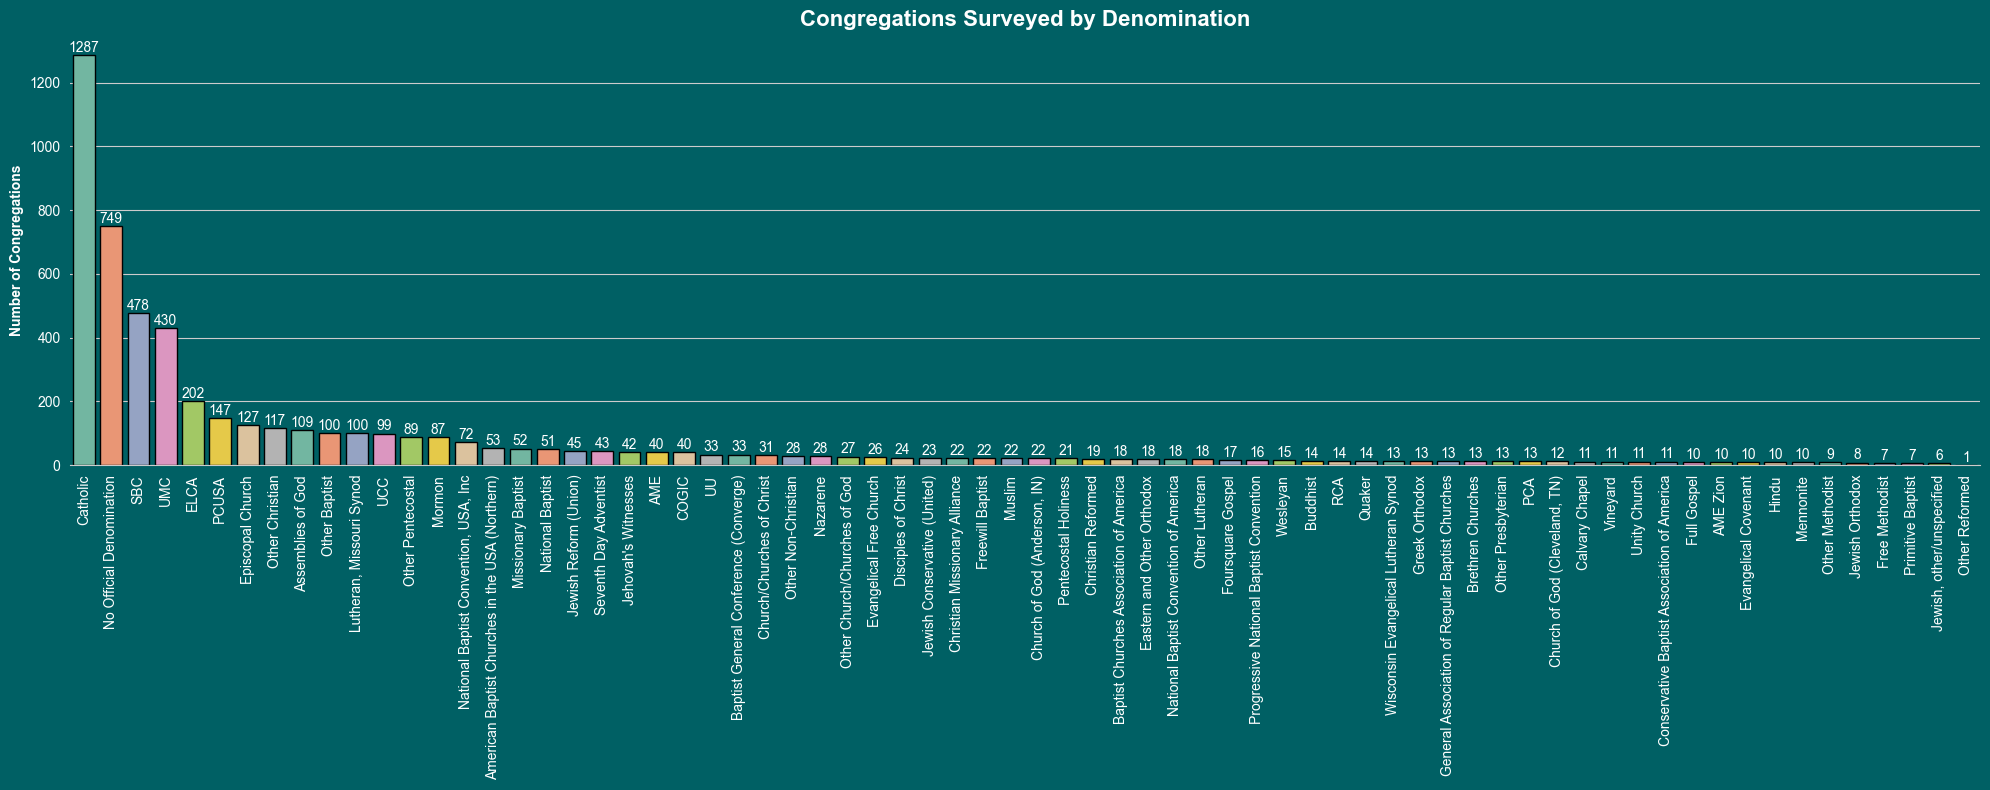

In [11]:
# Count the occurrences of each unique value in 'DENOM' column
denom_counts = data['DENOM'].value_counts().sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(20, 8))
ax = sns.barplot(x=denom_counts.index, y=denom_counts.values, palette='Set2', edgecolor='black', order=denom_counts.index)

# Customize the plot
plt.title('Congregations Surveyed by Denomination', fontsize=16, fontweight='bold')
plt.xlabel('', fontsize=12, fontweight='bold')
plt.ylabel('Number of Congregations', fontweight='bold')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Add data labels
for i, value in enumerate(denom_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

# Show the plot
plt.show()

In [ ]:
# Convert to DataFrame
denom_counts_df = denom_counts.reset_index()
denom_counts_df.columns = ['DENOM', 'Count']

# Export to Excel
output_file = 'denom_counts.xlsx'
denom_counts_df.to_excel(output_file, index=False)

print(f"Exported the list to {output_file}")

Exported the list to denom_counts.xlsx
                                              DENOM  Count
0                                          Catholic   1287
1                          No Official Denomination    749
2                                               SBC    478
3                                               UMC    430
4                                              ELCA    202
5                                             PCUSA    147
6                                  Episcopal Church    127
7                                   Other Christian    117
8                                 Assemblies of God    109
9                                     Other Baptist    100
10                         Lutheran, Missouri Synod    100
11                                              UCC     99
12                                Other Pentecostal     89
13                                           Mormon     87
14            National Baptist Convention, USA, Inc     72
15  American Bapt

In [ ]:
# Count unique values of DENOM
unique_denoms_count = data['DENOM'].nunique()

# Display the count
print("Number of unique denominations surveyed:")
print(unique_denoms_count)

Number of unique denominations surveyed:
70


In [ ]:
# Calculate frequency of each denomination
denom_counts = data['DENOM'].value_counts()

# Calculate cumulative percentage
denom_cumulative_percentage = denom_counts.cumsum() / denom_counts.sum() * 100

# Identify denominations that make up >= 80% of the total
denoms_80_percent = denom_cumulative_percentage[denom_cumulative_percentage <= 80].index

# List them in order of largest to smallest
denoms_80_percent_sorted = denom_counts[denoms_80_percent].sort_values(ascending=False)

# Display the denominations
print("Denominations that make up greater than or equal to 80% of the total surveyed denominations (in order of largest to smallest):")
print(denoms_80_percent_sorted)

Denominations that make up greater than or equal to 80% of the total surveyed denominations (in order of largest to smallest):
DENOM
Catholic                                           1287
No Official Denomination                            749
SBC                                                 478
UMC                                                 430
ELCA                                                202
PCUSA                                               147
Episcopal Church                                    127
Other Christian                                     117
Assemblies of God                                   109
Other Baptist                                       100
Lutheran, Missouri Synod                            100
UCC                                                  99
Other Pentecostal                                    89
Mormon                                               87
National Baptist Convention, USA, Inc                72
American Baptist Churches i

C:\Users\natha\AppData\Local\Temp\ipykernel_11524\1726980030.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='DENOM', data=df_top_denoms, palette='Set2')


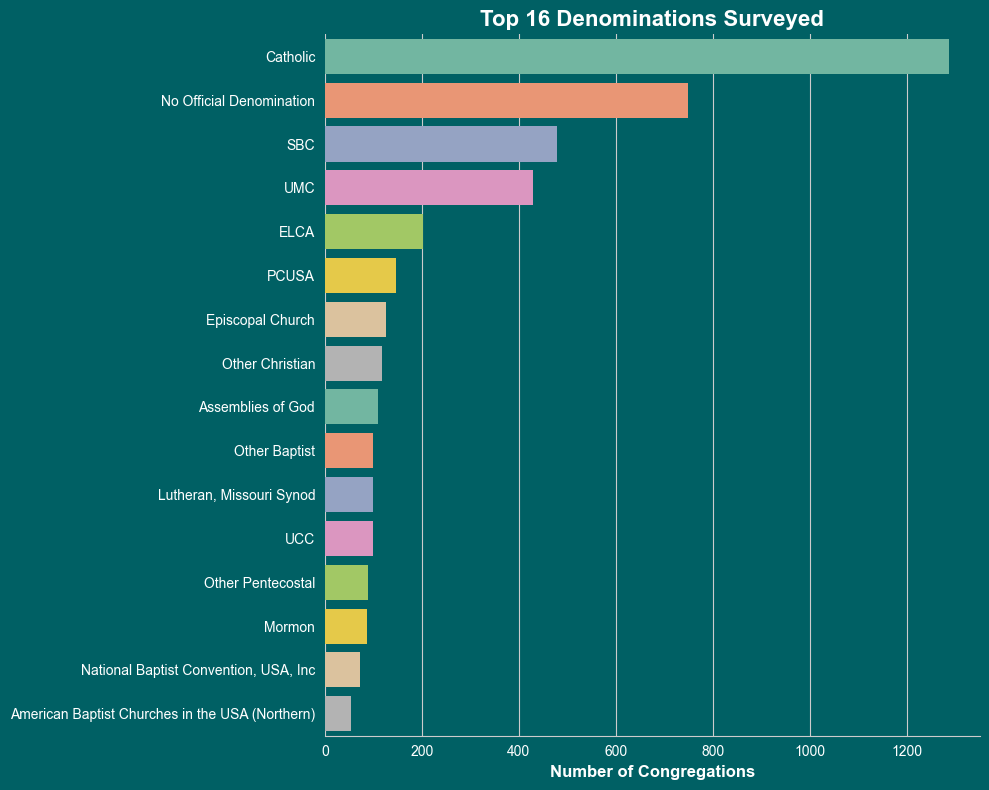

In [ ]:
# Define the data
data1 = {
    'DENOM': [
        'Catholic', 
        'No Official Denomination', 
        'SBC', 
        'UMC', 
        'ELCA', 
        'PCUSA', 
        'Episcopal Church', 
        'Other Christian', 
        'Assemblies of God', 
        'Other Baptist', 
        'Lutheran, Missouri Synod', 
        'UCC', 
        'Other Pentecostal', 
        'Mormon', 
        'National Baptist Convention, USA, Inc', 
        'American Baptist Churches in the USA (Northern)'
    ],
    'Count': [
        1287, 
        749, 
        478, 
        430, 
        202, 
        147, 
        127, 
        117, 
        109, 
        100, 
        100, 
        99, 
        89, 
        87, 
        72, 
        53
    ]
}

# Create DataFrame
df_top_denoms = pd.DataFrame(data1)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='DENOM', data=df_top_denoms, palette='Set2')

# Customize the plot
plt.title('Top 16 Denominations Surveyed', fontsize=16, fontweight='bold')
plt.xlabel('Number of Congregations', fontsize=12, fontweight='bold')
plt.ylabel('', fontsize=12, fontweight='bold')
plt.tight_layout()

# Show the plot
plt.show()

## Exploratory Data Analysis (EDA)
Correlation Analysis: Use correlation matrices to identify relationships between congregational offerings and attendance.<br>
Visualization: Create visualizations such as histograms, box plots, scatter plots, and heatmaps to explore patterns and trends.

## Inferential Analysis
Hypothesis Testing: Conduct hypothesis tests (e.g., t-tests, ANOVA) to determine if there are statistically significant differences in attendance based on different offerings.

## Regression Analysis
Linear Regression: Model the relationship between congregational size (dependent variable) and offerings (independent variables) using linear regression.<br>
Logistic Regression: If the outcome is categorical (e.g., increased attendance vs. no increase), use logistic regression.

## Multivariate Analysis
Multiple Regression: Extend linear regression to include multiple independent variables to account for the effect of various factors simultaneously.<br>
Principal Component Analysis (PCA): Reduce dimensionality and identify key factors contributing to attendance changes.

## Time Series Analysis
Trend Analysis: Examine how congregational size and offerings have changed over time.<br>
Seasonality: Identify seasonal patterns in attendance.

## Predictive Analysis
Machine Learning Models: Implement machine learning models (e.g., decision trees, random forests, gradient boosting) to predict attendance based on congregational offerings.<br>
Model Evaluation: Use cross-validation and performance metrics (e.g., RMSE, AUC) to assess model accuracy.

## Causal Analysis
Causal Inference: Use methods like propensity score matching or instrumental variables to identify causal relationships between offerings and attendance.

## Recommendations
Actionable Insights: Provide recommendations based on the analysis, highlighting which factors most significantly influence attendance.<br>
Scenario Analysis: Simulate different scenarios to predict the impact of changes in offerings on attendance.

## Seaborn Graph/Chart Theme